# Reproduction de l'algorithme PSOIFCM (Kumar & Kumar, 2022)

Ce notebook a pour objectif de **reproduire et d'analyser** l'algorithme de clustering
PSOIFCM (*Particle Swarm Optimization Improved Fuzzy C-Means*) proposé dans :

> N. Kumar, H. Kumar,  
> *A fuzzy clustering technique for enhancing the convergence performance by using improved Fuzzy c-means and Particle Swarm Optimization algorithms*,  
> Data & Knowledge Engineering, 2022.

---

## Sommaire

1. [Imports et configuration](#1-Imports-et-configuration)
2. [Rappel théorique sur PSO](#2-Rappel-théorique-sur-PSO)  
   2.1. [Équations de mise à jour](#21-Équations-de-mise-à-jour)  
   2.2. [Rôle des hyperparamètres](#22-Rôle-des-hyperparamètres)
3. [Rappel sur IFCM et distance proposée](#3-Rappel-sur-IFCM-et-distance-proposée)  
   3.1. [Distance $d_{\text{new}}$](#31-Distance-d_new)  
   3.2. [Fonction objectif IFCM](#32-Fonction-objectif-IFCM)
4. [Implémentation de l'algorithme PSOIFCM](#4-Implémentation-de-lalgorithme-PSOIFCM)  
   4.1. [Fonctions utilitaires](#41-Fonctions-utilitaires)  
   4.2. [PSO pour l'initialisation des centroïdes](#42-PSO-pour-linitialisation-des-centroïdes)  
   4.3. [IFCM : mises à jour](#43-IFCM--mises-à-jour)  
   4.4. [Fonction `psoifcm`](#44-Fonction-psoifcm)
5. [Pipeline générique d'expérimentation et visualisation](#5-Pipeline-générique-dexpérimentation)
6. [Application à différents datasets](#6-Application-à-Iris)



In [14]:
# ============================================
# 1. Imports et configuration
# ============================================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment


## 2. Rappel théorique sur PSO

La **Particle Swarm Optimization (PSO)** est une métaheuristique d'optimisation
inspirée des comportements collectifs (essaims d'oiseaux, bancs de poissons).
Chaque solution candidate est une *particule* caractérisée par :

- une **position** $x_i^{(t)}$,
- une **vitesse** $v_i^{(t)}$,
- un **meilleur point personnel** $P_i^{(t)}$,
- un **meilleur point global** $G^{(t)}$.

### 2.1 Équations de mise à jour (Eqs. (2)–(3))

Les équations de mise à jour utilisées dans l'article sont :

$$
v_i^{(t+1)} = \omega\, v_i^{(t)}
\;+\; \gamma_1 \eta_1 (P_i^{(t)} - x_i^{(t)})
\;+\; \gamma_2 \eta_2 (G^{(t)} - x_i^{(t)}),
\tag{2}
$$

$$
x_i^{(t+1)} = x_i^{(t)} + v_i^{(t+1)}.
\tag{3}
$$

### 2.2 Rôle des hyperparamètres

Les hyperparamètres principaux sont :

- $\omega$ : poids d'inertie,
- $\gamma_1, \gamma_2$ : coefficients d'accélération (cognitif / social),
- $\eta_1, \eta_2$ : facteurs aléatoires (ou constants dans l'article),
- nombre maximal d'itérations,
- critère d'arrêt (variance des fitness).

Dans l'article, les auteurs utilisent (Section 5.1) :

- $\gamma_1 = \gamma_2 = 1.49$,
- $\omega = 0.9$,
- $\eta_1 = 0.5949$,
- $\eta_2 = 0.0855$,
- nombre max d'itérations PSO : 50,
- $\varepsilon = 10^{-3}$ comme seuil de convergence.

**Intuition :**

- $\omega$ contrôle l'importance de la vitesse passée → équilibre exploration / exploitation.
- $\gamma_1 \eta_1$ contrôle la tendance à revenir vers le meilleur personnel (exploration locale).
- $\gamma_2 \eta_2$ contrôle la tendance à suivre le meilleur global (exploitation).
- Le critère de variance des fitness (Eq. (12)) vise à détecter quand les particules
  se comportent de façon similaire (convergence de l'essaim).


## 3. Rappel sur IFCM et distance proposée

### 3.1 Distance $d_{\text{new}}$

Les auteurs introduisent une distance modifiée (Eq. (4)) pour rendre FCM plus robuste au bruit.  
Dans la version du papier, on trouve un facteur écrit $(-1)^{u_i}$, mais pour que
la distance soit bien dans $[0,1]$ et décroissante avec la distance euclidienne,
on retient la formulation cohérente suivante (exponentielle négative) :

$$
d_{\mathrm{new}}(x_i, y_k)
    = 1 - \exp\!\left(
        - u_i \,
        \frac{\lVert x_i - y_k \rVert^{2}}{\sigma^{2}}
      \right),
\tag{4}
$$

où :

$$
u_i =
\sqrt{
\left|
\frac{1}{d} \sum_{j=1}^{d} a_{ij} + 1
\right|
},
\tag{13}
$$

avec $a_{ij}$ la $j$-ème coordonnée du point $x_i$ (dans un espace de dimension $d$).

Le paramètre $\sigma^2$ est choisi comme la **variance globale du jeu de données**,  
ce qui permet de normaliser la distance et d’éviter d'introduire un hyperparamètre supplémentaire.

---

### 3.2 Fonction objectif IFCM (Eq. (5))

L'objectif (Eq. (5)) du **Improved FCM (IFCM)** est :

$$
F(X, C, \mu) =
\sum_{i=1}^{n} \sum_{k=1}^{c}
\mu_{ki}^{\,m}
\left[
 1 - \exp\!\left(
   - u_i \,
   \frac{\lVert x_i - C_k \rVert^{2}}{\sigma^{2}}
 \right)
\right],
\tag{5}
$$

avec :

- $n$ : nombre de points,  
- $c$ : nombre de clusters,  
- $C_k$ : centroïde du cluster $k$,  
- $\mu_{ki}$ : degré d'appartenance de $x_i$ au cluster $k$,  
- $m > 1$ : exposant de flou (dans l'article, $m = 2$).

Les mises à jour des centroïdes et des appartenances (Eqs. (18) et (19) dans l’article)
s’obtiennent en minimisant $F$ sous les contraintes :

- $\sum_k \mu_{ki} = 1$ pour tout $i$,  
- $\mu_{ki} \in [0,1]$.

---



In [20]:
# ============================================
# PSO pour l'initialisation des centroïdes
# ============================================

def init_centroids_block(X, c):
    """
    Initialisation de type Eq. (14) :
    - tri implicite des points dans l'ordre,
    - division en c blocs de taille g ~ n/c,
    - moyenne de chaque bloc pour former un centroïde initial.

    Paramètres
    ----------
    X : ndarray (n, d)
    c : int, nombre de clusters

    Retour
    ------
    C0 : ndarray (c, d)
    """
    n, d = X.shape
    g = n // c
    C0 = []
    start = 0
    for k in range(c):
        end = n if k == c - 1 else start + g
        block = X[start:end]
        if len(block) == 0:
            # secours : centre aléatoire
            block = X[np.random.randint(n, size=1)]
        C0.append(block.mean(axis=0))
        start = end
    return np.vstack(C0)


def pso_initialize_centroids(X, params):
    """
    Utilise PSO pour affiner l'initialisation des centroïdes.

    Chaque particule = un centroïde (vecteur de dimension d).
    Fitness associée à un centroïde C_k :
        f_k = 1 / (J_k + xi), avec J_k = sum_i d_new(x_i, C_k)

    Paramètres
    ----------
    X : ndarray (n, d)
    params : dict, contient c, omega, gamma1, gamma2, eta1, eta2, pso_eps, pso_max_iter

    Retour
    ------
    C : ndarray (c, d) centroïdes après PSO
    """
    n, d = X.shape
    c = params["c"]

    # Pré-calculs
    u = compute_u_i(X)
    sigma2 = compute_sigma2(X)

    # Position initiale des particules = centroïdes initiaux (Eq. 14)
    C = init_centroids_block(X, c)           # shape (c, d)
    V = np.zeros_like(C)                     # vitesses initiales

    omega  = params["omega"]
    gamma1 = params["gamma1"]
    gamma2 = params["gamma2"]
    eta1   = params["eta1"]
    eta2   = params["eta2"]
    eps    = params["pso_eps"]
    max_it = params["pso_max_iter"]

    def J_of(Ck):
        """J_k = sum_i d_new(x_i, C_k) pour un centroïde C_k donné."""
        diff = X - Ck
        d2 = np.sum(diff**2, axis=1)
        expo = -u * d2 / (sigma2 + 1e-12)
        dnew = 1.0 - np.exp(expo)
        return np.sum(dnew)

    xi = 1e-12
    J = np.array([J_of(C[k]) for k in range(c)])
    f = 1.0 / (J + xi)

    pbest = C.copy()
    pbest_f = f.copy()
    gbest = C[np.argmax(f)].copy()

    for _ in range(max_it):
        # Mise à jour des vitesses et positions pour chaque centroïde-particule
        V = (omega * V
             + gamma1 * eta1 * (pbest - C)
             + gamma2 * eta2 * (gbest[None, :] - C))
        C = C + V

        # Recalcule J_k et fitness
        J = np.array([J_of(C[k]) for k in range(c)])
        f = 1.0 / (J + xi)

        # Mise à jour pbest et gbest
        improved = f > pbest_f
        pbest[improved] = C[improved]
        pbest_f[improved] = f[improved]

        gbest = pbest[np.argmax(pbest_f)].copy()

        # Critère de variance (Eq. 12)
        favg = np.mean(f)
        var_f = np.max((f - favg)**2/f)
        if var_f < eps:
            break

    return pbest  # centroïdes optimisés


In [36]:
# ============================================
# Fonctions utilitaires pour IFCM 
# ============================================


def compute_u_i(X):
    """
    Calcule u_i pour chaque point x_i (Eq. 13) :
        u_i = sqrt( | mean_j (a_ij) + 1 | )

    Paramètres
    ----------
    X : ndarray de forme (n, d)
        n = nombre de points, d = nombre de features

    Retour
    ------
    u : ndarray de forme (n,)
        un scalaire u_i par point x_i
    """
    mean_vals = X.mean(axis=1)          # moyenne sur les features pour chaque point
    return np.sqrt(np.abs(mean_vals + 1.0))


def compute_sigma2(X):
    """
    Calcule sigma^2 comme la variance globale du jeu de données.
    (Step 2 de l'algorithme dans l'article)

    Paramètres
    ----------
    X : ndarray (n, d)

    Retour
    ------
    sigma2 : float
    """
    return np.var(X)


def d_new_matrix(X, C, u, sigma2):
    """
    Calcule d_new(x_i, C_k) pour toutes les paires (i, k), sous forme de matrice (n, c).

    d_new(x_i, C_k) = 1 - exp( - u_i * ||x_i - C_k||^2 / sigma^2 )

    Paramètres
    ----------
    X : ndarray (n, d)
    C : ndarray (c, d)
    u : ndarray (n,)
    sigma2 : float

    Retour
    ------
    D : ndarray (n, c)
        D[i, k] = d_new(x_i, C_k)
    """
    # Différences x_i - C_k pour toutes les paires
    diff = X[:, None, :] - C[None, :, :]   # shape (n, c, d)
    d2 = np.sum(diff**2, axis=2)           # ||x_i - C_k||^2 -> (n, c)
    expo = - u[:, None] * d2 / (sigma2 + 1e-12)
    return 1.0 - np.exp(expo)


def objective_ifcm(X, C, U, u, sigma2, m):
    """
    Fonction objectif IFCM (Eq. 5) :
        F(X, C, mu) = sum_i sum_k mu_ki^m * d_new(x_i, C_k)

    Paramètres
    ----------
    X : ndarray (n, d)
    C : ndarray (c, d)
    U : ndarray (c, n)  -- matrice de memberships
    u : ndarray (n,)
    sigma2 : float
    m : float

    Retour
    ------
    F : float
    """
    D = d_new_matrix(X, C, u, sigma2)    # (n, c)
    # U.T : (n, c) ; on élève à m et on multiplie élément à élément
    return np.sum((U.T ** m) * D)

In [38]:
# ============================================
#  IFCM : mises à jour
# ============================================

def ifcm(X, C_init, params):
    """
    Applique l'IFCM en utilisant les centroïdes initialisés par PSO.

    Paramètres
    ----------
    X : ndarray (n, d)
    C_init : ndarray (c, d)
    params : dict, contient c, m, ifcm_eps, ifcm_max_iter

    Retour
    ------
    C : ndarray (c, d)  -- centroïdes finaux
    U : ndarray (c, n)  -- appartenances finales
    F : float           -- valeur finale de la fonction objectif
    """
    n, d = X.shape
    c = params["c"]
    m = params["m"]
    eps = params["ifcm_eps"]
    max_it = params["ifcm_max_iter"]

    u = compute_u_i(X)
    sigma2 = compute_sigma2(X)

    # Initialisation des appartenances aléatoires (normalisées colonne par colonne)
    rng = np.random.default_rng(42)
    U = rng.random((c, n))
    U /= U.sum(axis=0, keepdims=True)

    C = C_init.copy()

    for _ in range(max_it):
        U_old = U.copy()

        # Mise à jour des centroïdes (Eq. 18)
        D = d_new_matrix(X, C, u, sigma2)     # (n, c)
        G = 1.0 - D                           # G_ik = exp(-u_i ||x_i - C_k||^2 / sigma^2)

        # poids w_ik = mu_ki^m * G_ik * u_i
        W = (U.T**m) * G * u[:, None]         # shape (n, c)

        num = np.einsum("nk,nd->kd", W, X)    # somme sur i
        den = W.sum(axis=0) + 1e-12
        C = num / den[:, None]

        # Mise à jour des appartenances (Eq. 19)
        D = d_new_matrix(X, C, u, sigma2)     # (n, c) recalculé
        eps_d = 1e-12
        ratio = (D[:, :, None] / (D[:, None, :] + eps_d)) ** (1.0 / (m - 1))
        denom = ratio.sum(axis=2)             # (n, c)
        U = 1.0 / (denom.T + eps_d)           # (c, n)

        # critère d'arrêt sur les appartenances
        if np.max(np.abs(U - U_old)) < eps:
            break

    F = objective_ifcm(X, C, U, u, sigma2, m)
    return C, U, F


In [ ]:
#  Fonction psoifcm

def psoifcm(X, params):
    """
    Pipeline complet PSOIFCM :
      1) PSO pour initialiser les centroïdes
      2) IFCM pour affiner la solution

    Paramètres
    ----------
    X : ndarray (n, d)
    params : dict

    Retour
    ------
    C : ndarray (c, d)
    U : ndarray (c, n)
    F : float
    """
    C_init = pso_initialize_centroids(X, params)
    C, U, F = ifcm(X, C_init, params)
    return C, U, F


In [40]:
# ============================================
# 5. Pipeline générique d'expérimentation et visualisation
# ============================================

def clustering_accuracy(y_true, y_pred):
    """
    Calcule l'accuracy maximale via appariement hongrois
    (pour gérer la permutation des labels de clusters).
    """
    cm = contingency_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()


def inter_cluster_distance(C):
    """
    ICD (Eq. 20) : min_{i<j} ||C_i - C_j||_2
    """
    c = C.shape[0]
    if c < 2:
        return 0.0
    diff = C[:, None, :] - C[None, :, :]
    D = np.sqrt(np.sum(diff**2, axis=2))
    D[np.arange(c), np.arange(c)] = np.inf
    return float(np.min(D))


def visualize_clustering(X, labels, y_true=None, title_prefix=""):
    """
    Visualise le clustering en 2D :
      - si d = 2 : on affiche directement les features
      - sinon : ACP sur les 2 premières composantes, avec variance expliquée affichée

    Paramètres
    ----------
    X : ndarray (n, d)
    labels : ndarray (n,)
        labels de clusters prédits
    y_true : ndarray (n,) ou None
        labels "vrais" (si disponibles)
    """
    n, d = X.shape
    if d == 2:
        X_2d = X
        explained = None
    else:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        explained = pca.explained_variance_ratio_.sum()

    fig, axes = plt.subplots(1, 2 if y_true is not None else 1, figsize=(12, 5))

    if y_true is None:
        ax = axes if isinstance(axes, plt.Axes) else axes[0]
        sc = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="viridis")
        s_title = f"{title_prefix} - Clusters PSOIFCM"
        if explained is not None:
            s_title += f" (ACP, {explained*100:.1f}% variance)"
        ax.set_title(s_title)
        plt.colorbar(sc, ax=ax)
    else:
        ax_true, ax_pred = axes
        sc1 = ax_true.scatter(X_2d[:, 0], X_2d[:, 1], c=y_true, cmap="viridis")
        t1 = f"{title_prefix} - Vrais labels"
        if explained is not None:
            t1 += f" (ACP, {explained*100:.1f}% variance)"
        ax_true.set_title(t1)
        plt.colorbar(sc1, ax=ax_true)

        sc2 = ax_pred.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="viridis")
        t2 = f"{title_prefix} - Clusters PSOIFCM"
        if explained is not None:
            t2 += f" (ACP, {explained*100:.1f}% variance)"
        ax_pred.set_title(t2)
        plt.colorbar(sc2, ax=ax_pred)

    plt.tight_layout()
    plt.show()


def run_experiment(X, y_true=None, dataset_name="Dataset", params_override=None):
    """
    Pipeline complet :
      - lance PSOIFCM sur X
      - calcule OFV, ICD, accuracy (si y_true fourni)
      - affiche les clusters (2D ou ACP)

    Paramètres
    ----------
    X : ndarray (n, d)
    y_true : ndarray (n,) ou None
    dataset_name : str
    params_override : dict ou None
        permet de surcharger certains champs de params
        (par exemple params_override={"c": 3})

    Retour
    ------
    C, U, F, metrics : (ndarray, ndarray, float, dict)
    """
    p = params.copy()
    if params_override is not None:
        p.update(params_override)

    C, U, F = psoifcm(X, p)
    labels = np.argmax(U, axis=0)

    metrics = {"OFV": F, "ICD": inter_cluster_distance(C)}
    if y_true is not None:
        metrics["accuracy"] = clustering_accuracy(y_true, labels)

    print(f"=== Résultats pour {dataset_name} ===")
    print(f"OFV (fonction objectif) : {metrics['OFV']:.4f}")
    print(f"ICD (min distance inter-centres) : {metrics['ICD']:.4f}")
    if "accuracy" in metrics:
        print(f"Accuracy (après appariement) : {metrics['accuracy']*100:.2f}%")

    visualize_clustering(X, labels, y_true=y_true, title_prefix=dataset_name)
    return C, U, F, metrics


In [42]:
params = {
    "m": 2.0, # fuzzy indew
    "omega": 0.9, # inertia
    "gamma1": 1.49, # personal acceleration 
    "gamma2": 1.49, # global acceleration
    "eta1": 0.5949, # uniform [0,1]
    "eta2": 0.0855, # uniform [0,1]
    "pso_eps": 1e-3, # seuil pour critère d'arret PSO
    "pso_max_iter": 50, # max iter pso
    "ifcm_eps": 1e-3, # seuil pour ifcm sur la variation des memberships
    "ifcm_max_iter": 300, # max iter ifcm 
}

# Application de PSOFICM sur différents datasets 

=== Résultats pour Iris ===
OFV (fonction objectif) : 18.7409
ICD (min distance inter-centres) : 1.4602
Accuracy (après appariement) : 92.00%


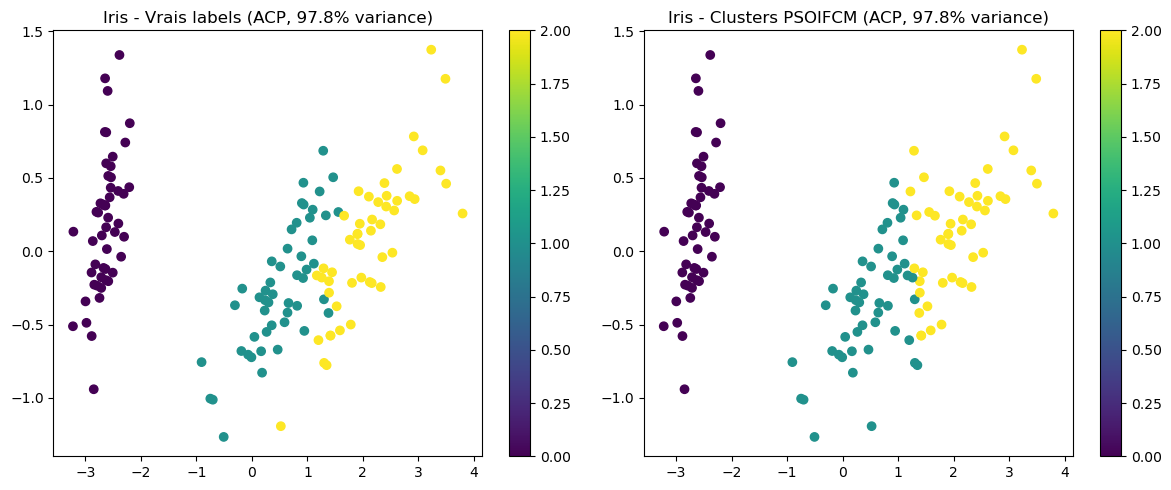

In [44]:
# ============================================
#  Application à Iris
# ============================================

from sklearn.datasets import load_iris

iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Nombre de clusters = 3 pour Iris
C_iris, U_iris, F_iris, metrics_iris = run_experiment(
    X_iris,
    y_true=y_iris,
    dataset_name="Iris",
    params_override={"c": 3}
)


Shape X_wine : (178, 13)
Nb de classes : 3
=== Résultats pour Wine ===
OFV (fonction objectif) : 37.8743
ICD (min distance inter-centres) : 169.7384
Accuracy (après appariement) : 72.47%


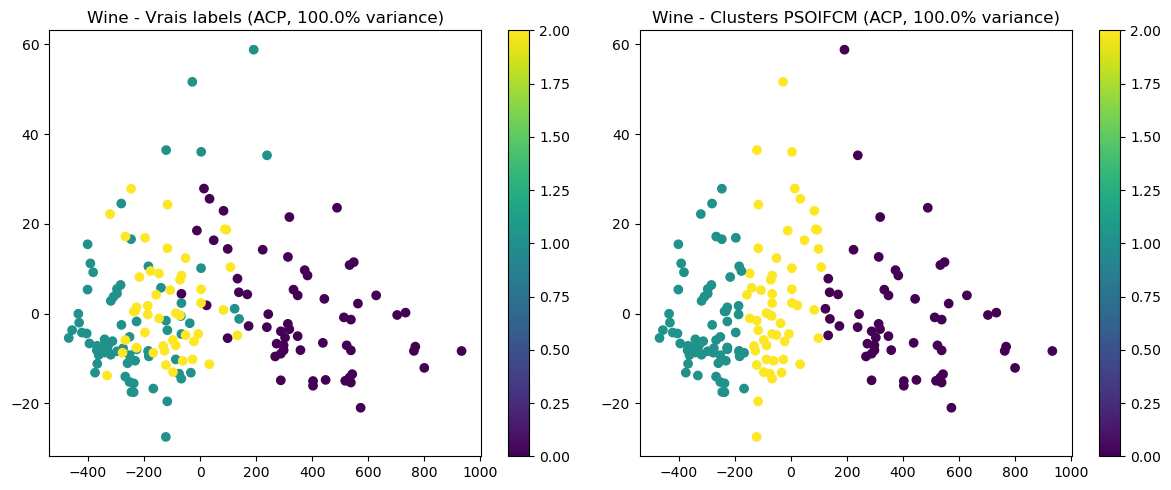

{'OFV': 37.87427169219929, 'ICD': 169.73841106317508, 'accuracy': 0.7247191011235955}


In [66]:
# ============================================
#  Application à Wine
# ============================================

from sklearn.datasets import load_wine

# Chargement du dataset Wine depuis scikit-learn
wine = load_wine()
X_wine = wine.data       # (n=178, d=13)
y_wine = wine.target     # 3 classes

print("Shape X_wine :", X_wine.shape)
print("Nb de classes :", len(np.unique(y_wine)))

# Nombre de clusters = 3 pour Wine
C_wine, U_wine, F_wine, metrics_wine = run_experiment(
    X_wine,
    y_true=y_wine,
    dataset_name="Wine",
    params_override={"c": 3}
)

print(metrics_wine)


=== Résultats pour Two Moons ===
OFV (fonction objectif) : 315.5167
ICD (min distance inter-centres) : 1.4945
Accuracy (après appariement) : 81.90%


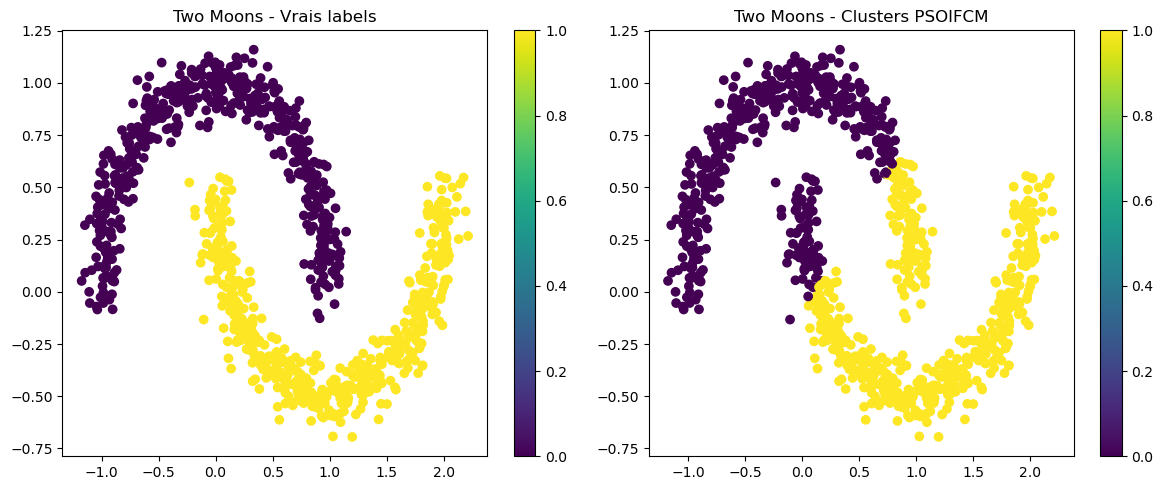

In [46]:
# ============================================
#  Application à Two Moons
# ============================================

from sklearn.datasets import make_moons

# Génération du dataset Two Moons
X_moons, y_moons = make_moons(n_samples=1000, noise=0.08, random_state=42)

# Nombre de clusters = 2 pour Two Moons
C_moons, U_moons, F_moons, metrics_moons = run_experiment(
    X_moons,
    y_true=y_moons,
    dataset_name="Two Moons",
    params_override={"c": 2}
)

=== Résultats pour Concentric Circles ===
OFV (fonction objectif) : 314.8349
ICD (min distance inter-centres) : 0.6764
Accuracy (après appariement) : 50.80%


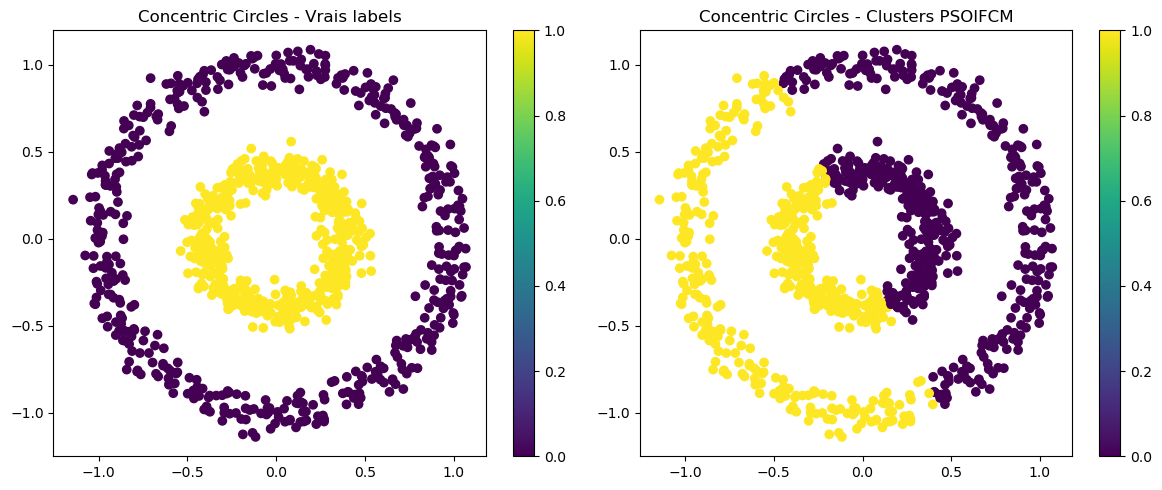

In [48]:
# ============================================
# Application à Concentric Circles
# ============================================

from sklearn.datasets import make_circles

X_circ, y_circ = make_circles(
    n_samples=1000,
    factor=0.4,      # taille du cercle intérieur
    noise=0.06,
    random_state=42
)

C_circ, U_circ, F_circ, metrics_circ = run_experiment(
    X_circ,
    y_true=y_circ,
    dataset_name="Concentric Circles",
    params_override={"c": 2}
)

=== Résultats pour Anisotropic Blobs ===
OFV (fonction objectif) : 133.5453
ICD (min distance inter-centres) : 1.5670
Accuracy (après appariement) : 84.60%


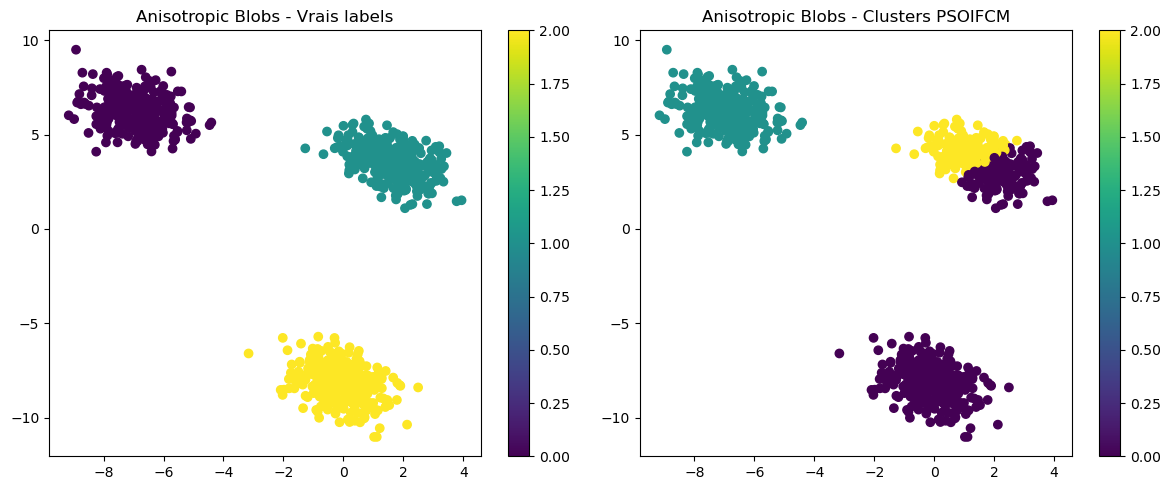

In [50]:
# ============================================
# Application à des blobs anisotropes
# ============================================

from sklearn.datasets import make_blobs

# Blobs isotropes au départ
X_aniso, y_aniso = make_blobs(
    n_samples=1000,
    centers=3,
    cluster_std=1.0,
    random_state=42
)

# Transformation linéaire pour rendre les clusters anisotropes
transformation = np.array([[0.6, -0.6],
                           [0.4,  0.8]])
X_aniso = X_aniso @ transformation.T  # produit matriciel

C_aniso, U_aniso, F_aniso, metrics_aniso = run_experiment(
    X_aniso,
    y_true=y_aniso,
    dataset_name="Anisotropic Blobs",
    params_override={"c": 3}
)

=== Résultats pour Blobs Densités Variées ===
OFV (fonction objectif) : 135.9503
ICD (min distance inter-centres) : 0.9750
Accuracy (après appariement) : 75.90%


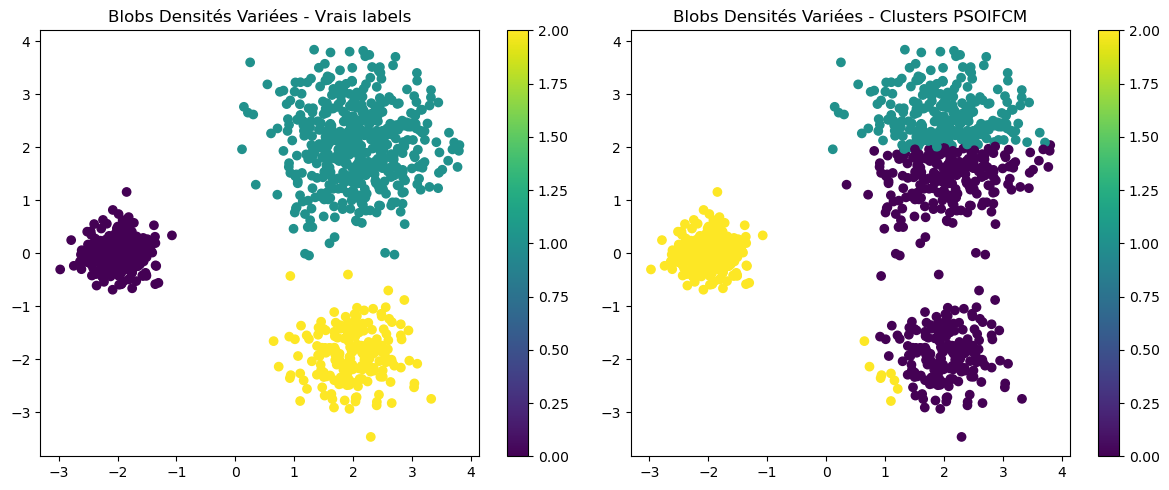

In [54]:
# ============================================
# Application à des blobs de densités variées
# ============================================

from sklearn.datasets import make_blobs

X_var, y_var = make_blobs(
    n_samples=[300, 500, 200],   # tailles différentes
    centers=[[-2, 0], [2, 2], [2, -2]],
    cluster_std=[0.3, 0.7, 0.5], # densités / dispersions différentes
    random_state=42
)

C_var, U_var, F_var, metrics_var = run_experiment(
    X_var,
    y_true=y_var,
    dataset_name="Blobs Densités Variées",
    params_override={"c": 3}
)